In [10]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np

# Load US states map
us_states = gpd.read_file('/data/sg/munjkim/USPTO/nokia_intern/data/raw/naturalearth_lowers/')


Figure 3

# Data Loading

In [6]:
inventor_table = pd.read_csv('/data/sg/munjkim/USPTO/nokia_intern/data/raw/patentsview/g_inventor_disambiguated.tsv', on_bad_lines= 'skip', sep ='\t')
assignee_table = pd.read_csv('/data/sg/munjkim/USPTO/nokia_intern/data/raw/patentsview/g_assignee_disambiguated.tsv', on_bad_lines= 'skip', sep ='\t')



In [7]:
disruptive_tasks = pd.read_csv('/data/sg/munjkim/USPTO/nokia_intern/data/processed/disruptive_tasks.csv', on_bad_lines= 'skip')
consolidating_tasks = pd.read_csv('/data/sg/munjkim/USPTO/nokia_intern/data/processed/consolidating_tasks.csv', on_bad_lines= 'skip')


In [11]:
occupations = pd.read_csv('/data/sg/munjkim/USPTO/nokia_intern/data/raw/ONET_ALI/db_24_3_text/Occupation Level Metadata.txt', sep='\t')

In [13]:
location_table = pd.read_csv('/data/sg/munjkim/USPTO/nokia_intern/data/raw/patentsview/g_location_disambiguated.tsv', on_bad_lines = 'skip', sep = '\t')

In [14]:
occupations_naics_sector = occupations[occupations['Item'] == 'NAICS Sector']
occupations_naics_sector['SOC Code'] = occupations_naics_sector['O*NET-SOC Code'].apply(lambda x: x[:7])
occupations_naics_sector_trust = occupations_naics_sector[occupations_naics_sector['Percent']>50]
occupations_naics_sector_trust_max = occupations_naics_sector_trust.loc[occupations_naics_sector_trust.groupby('SOC Code')['Percent'].idxmax()]

/tmp/ipykernel_121012/1837511247.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occupations_naics_sector['SOC Code'] = occupations_naics_sector['O*NET-SOC Code'].apply(lambda x: x[:7])


In [15]:
soc_code_to_response = dict(zip(occupations_naics_sector_trust_max ['SOC Code'], occupations_naics_sector_trust_max ['Response']))



In [16]:
disruptive_tasks['patent_id'] = disruptive_tasks['patent_id'].astype(str)
consolidating_tasks['patent_id'] = consolidating_tasks['patent_id'].astype(str)


In [105]:
tasks = pd.read_csv('../data/processed/tasks_matched_with_ai_patent_keywords_alicpc.csv')
quantile_threshold = tasks['patents_cosine_similarity'].quantile(0.9)
tasks_notexposedai = tasks[tasks['patents_cosine_similarity']<quantile_threshold]
tasks_exposedai = tasks[tasks['patents_cosine_similarity']>quantile_threshold]

In [106]:
tasks_exposedai['patent_id'] =tasks_exposedai['patent_id'].astype(str)

/tmp/ipykernel_12200/2269441982.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_exposedai['patent_id'] =tasks_exposedai['patent_id'].astype(str)


In [107]:
disruptive_tasks['SOC Code'] = disruptive_tasks['O*NET-SOC Code'].apply(lambda x: x[:7])
consolidating_tasks['SOC Code'] = consolidating_tasks['O*NET-SOC Code'].apply(lambda x: x[:7])
tasks_exposedai['SOC Code'] = tasks_exposedai['O*NET-SOC Code'].apply(lambda x: x[:7])

/tmp/ipykernel_12200/2886804240.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_exposedai['SOC Code'] = tasks_exposedai['O*NET-SOC Code'].apply(lambda x: x[:7])


In [108]:
disruptive_merge= pd.merge(disruptive_tasks,assignee_table, on ='patent_id',how='left' )

consolidating_merge= pd.merge(consolidating_tasks,assignee_table, on ='patent_id',how='left' )
tasks_merge= pd.merge(tasks_exposedai,assignee_table, on ='patent_id',how='left' )

## combining tasks and assignee of patent

In [109]:
tasks_merged_df = pd.merge(tasks_merge, location_table, on='location_id', how='left')



disruptive_merged_df = pd.merge(disruptive_merge, location_table, on='location_id', how='left')


consolidating_merged_df = pd.merge(consolidating_merge, location_table, on='location_id', how='left')




## combining tasks and location of the assignee of patent

In [110]:
geometry = [Point(xy) for xy in zip(tasks_merged_df['longitude'],tasks_merged_df['latitude'])]
gdf = gpd.GeoDataFrame(tasks_merged_df, geometry=geometry)
gdf = gpd.sjoin(gdf, us_states, how="inner")
    # Count patents per state
patent_counts = gdf['name'].value_counts().reset_index()
patent_counts.columns = ['state', 'patent_count']
total_patents = patent_counts['patent_count'].sum()
    
    # Convert counts to fractions of the total
patent_counts['patent_fraction'] = patent_counts['patent_count'] / total_patents

state_fraction_dict = patent_counts.set_index('state')['patent_fraction'].to_dict()
    

/tmp/ipykernel_12200/1878494615.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how="inner")


In [111]:


geometry = [Point(xy) for xy in zip(disruptive_merged_df['longitude'], disruptive_merged_df['latitude'])]
gdf_disruptive = gpd.GeoDataFrame(disruptive_merged_df, geometry=geometry)

# Spatial join points to the US states
gdf_disruptive = gpd.sjoin(gdf_disruptive, us_states, how="inner")



/tmp/ipykernel_12200/2015977970.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf_disruptive = gpd.sjoin(gdf_disruptive, us_states, how="inner")


In [112]:
# Count patents per state
patent_counts_disruptive = gdf_disruptive['name'].value_counts().reset_index()
patent_counts_disruptive.columns = ['state', 'patent_count']


In [113]:
total_patents_disruptive = patent_counts_disruptive['patent_count'].sum()

# Convert counts to fractions of the total
patent_counts_disruptive['patent_fraction'] = patent_counts_disruptive['patent_count'] / total_patents_disruptive


In [114]:
geometry = [Point(xy) for xy in zip(consolidating_merged_df['longitude'],consolidating_merged_df['latitude'])]
gdf = gpd.GeoDataFrame(consolidating_merged_df, geometry=geometry)

# Spatial join points to the US states
gdf = gpd.sjoin(gdf, us_states, how="inner")


/tmp/ipykernel_12200/135296190.py:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how="inner")


In [115]:
# Count patents per state
patent_counts = gdf['name'].value_counts().reset_index()
patent_counts.columns = ['state', 'patent_count']
total_patents = patent_counts['patent_count'].sum()

# Convert counts to fractions of the total
patent_counts['patent_fraction'] = patent_counts['patent_count'] / total_patents
us_states_merged = us_states.merge(patent_counts, left_on='name', right_on='state', how='left')


In [116]:
# patent_counts_disruptive['patent_fraction_difference'] = patent_counts_disruptive.apply(lambda x: x.patent_fraction - state_fraction_dict[x.state],axis=1)
us_states_merged_disruptive = us_states.merge(patent_counts_disruptive, left_on='name', right_on='state', how='left')


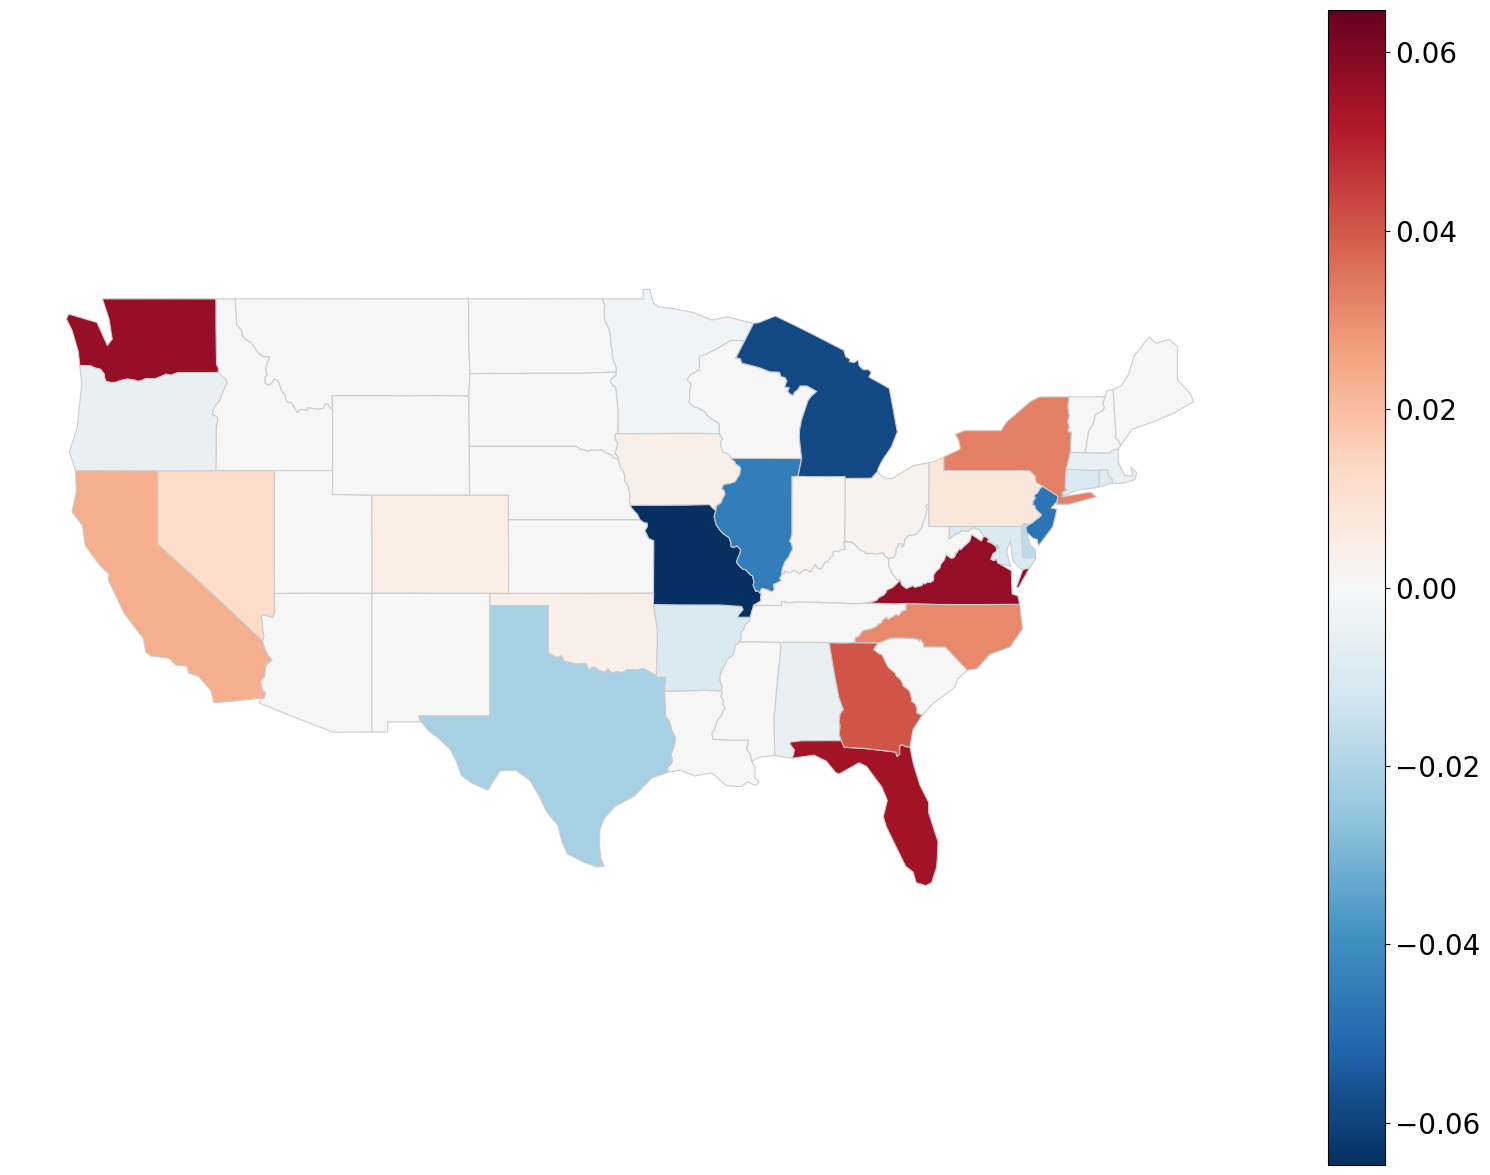

In [117]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

fig, ax = plt.subplots(1, 1, figsize=(20, 15))

# Assuming us_states_merged and us_states_merged_disruptive are already defined

us_states_merged['patent_fraction'] = us_states_merged['patent_fraction'].apply(lambda x: 0 if x != x else x)
us_states_merged_disruptive['patent_fraction'] = us_states_merged_disruptive['patent_fraction'].apply(lambda x: 0 if x != x else x)
us_states_merged_disruptive['patent_fraction_difference_disruptive_consolidating'] = us_states_merged['patent_fraction'] - us_states_merged_disruptive['patent_fraction']

# Multiply by -1 to invert the sign
us_states_merged_disruptive['patent_fraction_difference_disruptive_consolidating'] *= -1

max_abs_value = np.max(np.abs(us_states_merged_disruptive['patent_fraction_difference_disruptive_consolidating']))

# Create a diverging color map that is symmetrical around zero
norm = TwoSlopeNorm(vmin=-max_abs_value, vcenter=0, vmax=max_abs_value)

# Plot with reversed color map ('RdBu_r')
us_states_merged_disruptive[us_states_merged_disruptive['iso_3166_2'].apply(lambda x: x not in {'US-HI', 'US-AK'})].plot(
    column='patent_fraction_difference_disruptive_consolidating', 
    cmap='RdBu_r', 
    linewidth=0.8, 
    ax=ax, 
    edgecolor='0.8', 
    norm=norm, 
    legend=True
)
cbar = plt.gcf().get_axes()[1]  # Get the color bar axis
cbar.tick_params(labelsize=20)  # Set the font size for color bar ticks


# Remove ticks and spines
ax.set_yticks([])
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# plt.savefig('../../results/figures/Agglomeration_states_difference_disruptiveness_consolidating.png')
plt.show()


In [118]:
us_states = gpd.read_file('../data/raw/naturalearth_lowers/')
geometry = [Point(xy) for xy in zip(consolidating_merged_df['longitude'],consolidating_merged_df['latitude'])]
gdf = gpd.GeoDataFrame(consolidating_merged_df, geometry=geometry)

# Spatial join points to the US states
gdf = gpd.sjoin(gdf, us_states, how="inner")


/tmp/ipykernel_12200/3846546571.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how="inner")


In [119]:
# Count patents per state
patent_counts = gdf['name'].value_counts().reset_index()
patent_counts.columns = ['state', 'patent_count']
total_patents = patent_counts['patent_count'].sum()

# Convert counts to fractions of the total
patent_counts['patent_fraction'] = patent_counts['patent_count'] / total_patents
patent_counts['patent_fraction_difference'] = patent_counts.apply(lambda x: x.patent_fraction - state_fraction_dict[x.state],axis=1)
us_states_merged = us_states.merge(patent_counts, left_on='name', right_on='state', how='left')


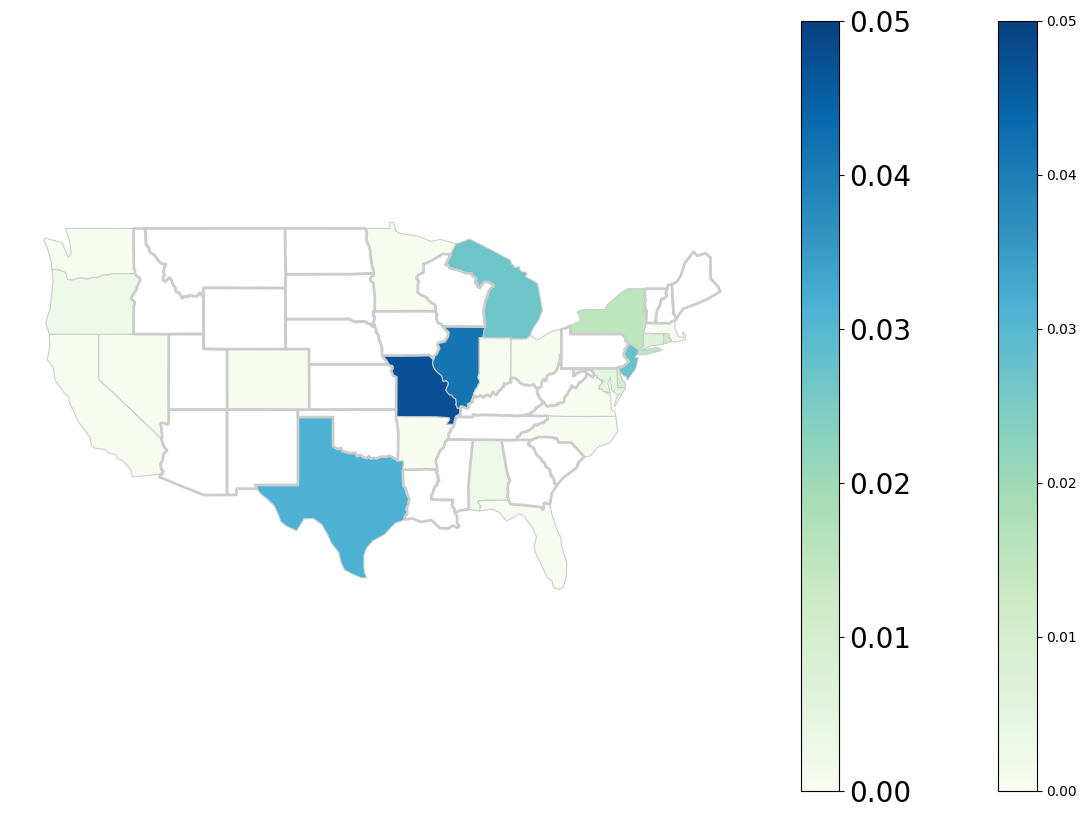

In [120]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Define normalization to restrict the color range
norm = mcolors.Normalize(vmin=0, vmax=0.05)

# Plot the map without Hawaii and Alaska, applying the normalization
us_states_merged[us_states_merged['iso_3166_2'].apply(lambda x: x not in {'US-HI','US-AK'})].plot(
    column='patent_fraction_difference', cmap='GnBu', linewidth=0.8, ax=ax, legend=True, edgecolor='0.8', norm=norm)

# Identify areas where 'patent_fraction_difference' is exactly zero
us_states_merged['patent_fraction_difference'] = us_states_merged['patent_fraction_difference'].apply(lambda x: 0 if x!=x else x)
zero_areas = us_states_merged[(us_states_merged['patent_fraction_difference'] == 0) & (us_states_merged['iso_3166_2'].apply(lambda x: x not in {'US-HI','US-AK'}))]

# Plot these areas with a distinct border color
zero_areas.plot(ax=ax, edgecolor='0.8', linewidth=2, facecolor='white')

# Add the color bar to the plot
cbar = plt.colorbar(ax.collections[0], ax=ax)

# Increase the tick label size for the color bar
cbar.ax.tick_params(labelsize=20)  # Adjust the font size as needed

ax.set_yticks([])
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Set the title
# ax.set_title('Fraction of Consolidating Patent Distribution Compared to Null Model')
# plt.savefig('../../results/figures/Agglomeration_states_difference_consolidating.pdf')
plt.show()


In [121]:

us_states = gpd.read_file('../data/raw/naturalearth_lowers/')
geometry = [Point(xy) for xy in zip(disruptive_merged_df['longitude'], disruptive_merged_df['latitude'])]
gdf_disruptive = gpd.GeoDataFrame(disruptive_merged_df, geometry=geometry)

# Spatial join points to the US states
gdf_disruptive = gpd.sjoin(gdf_disruptive, us_states, how="inner")

# Count patents per state
patent_counts_disruptive = gdf_disruptive['name'].value_counts().reset_index()
patent_counts_disruptive.columns = ['state', 'patent_count']

total_patents_disruptive = patent_counts_disruptive['patent_count'].sum()

# Convert counts to fractions of the total
patent_counts_disruptive['patent_fraction'] = patent_counts_disruptive['patent_count'] / total_patents_disruptive


/tmp/ipykernel_12200/4233319538.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf_disruptive = gpd.sjoin(gdf_disruptive, us_states, how="inner")


In [122]:
patent_counts_disruptive['patent_fraction_difference'] = patent_counts_disruptive.apply(lambda x: x.patent_fraction - state_fraction_dict[x.state],axis=1)
us_states_merged_disruptive = us_states.merge(patent_counts_disruptive, left_on='name', right_on='state', how='left')


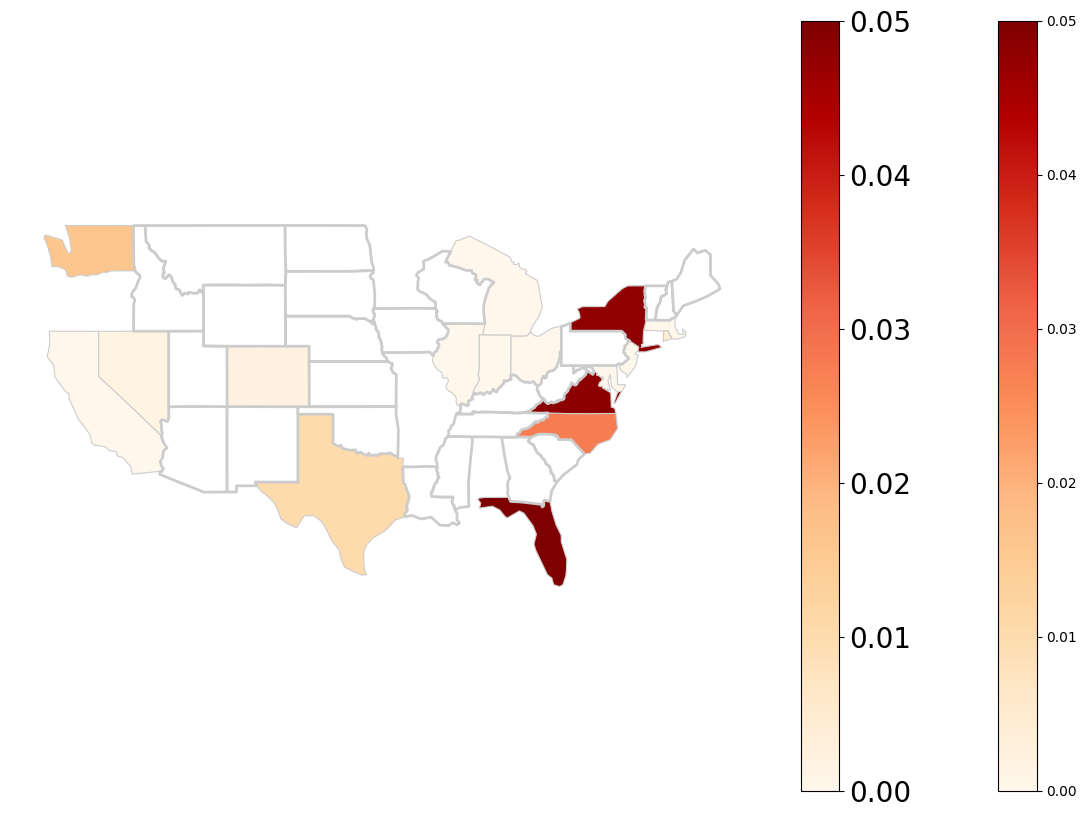

In [123]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Define normalization to restrict the color range
norm = mcolors.Normalize(vmin=0, vmax=0.05)
# us_states_merged_disruptive[us_states_merged_disruptive['iso_3166_2'].apply(lambda x: x not in {'US-HI','US-AK'})].plot(column='patent_fraction_difference', cmap='OrRd',legend=True, linewidth=0.8, ax=ax, edgecolor='0.8')

# Plot the map without Hawaii and Alaska, applying the normalization
us_states_merged_disruptive[us_states_merged_disruptive['iso_3166_2'].apply(lambda x: x not in {'US-HI','US-AK'})].plot(
    column='patent_fraction_difference', cmap='OrRd', linewidth=0.8, ax=ax, legend=True, edgecolor='0.8', norm=norm)

# Identify areas where 'patent_fraction_difference' is exactly zero
us_states_merged['patent_fraction_difference'] = us_states_merged['patent_fraction_difference'].apply(lambda x: 0 if x!=x else x)
zero_areas = us_states_merged[(us_states_merged['patent_fraction_difference'] == 0) & (us_states_merged['iso_3166_2'].apply(lambda x: x not in {'US-HI','US-AK'}))]

# Plot these areas with a distinct border color
zero_areas.plot(ax=ax, edgecolor='0.8', linewidth=2, facecolor='white')

# Add the color bar to the plot
cbar = plt.colorbar(ax.collections[0], ax=ax)

# Increase the tick label size for the color bar
cbar.ax.tick_params(labelsize=20)  # Adjust the font size as needed

ax.set_yticks([])
ax.set_xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Set the title
# ax.set_title('Fraction of Consolidating Patent Distribution Compared to Null Model')
# plt.savefig('../../results/figures/Agglomeration_states_difference_disruptive.pdf')
plt.show()


In [125]:
disruptive_tasks['task_industry'] = disruptive_tasks['SOC Code'].apply(lambda x: soc_code_to_response[x] if x in soc_code_to_response else np.nan)
consolidating_tasks['task_industry'] = consolidating_tasks['SOC Code'].apply(lambda x: soc_code_to_response[x] if x in soc_code_to_response else np.nan)
tasks_exposedai['task_industry'] = tasks_exposedai['SOC Code'].apply(lambda x: soc_code_to_response[x] if x in soc_code_to_response else np.nan)

/tmp/ipykernel_12200/1180987178.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_exposedai['task_industry'] = tasks_exposedai['SOC Code'].apply(lambda x: soc_code_to_response[x] if x in soc_code_to_response else np.nan)


In [152]:
from collections import Counter

Counter(tasks_exposedai['task_industry'])

Counter({nan: 528,
         'Manufacturing': 411,
         'Health care and social assistance': 330,
         'Transportation and warehousing': 107,
         'Professional, Scientific and Technical Services': 100,
         'Public administration': 97,
         'Construction': 66,
         'Utilities': 47,
         'Retail trade': 46,
         'Education services': 44,
         'Other services, except public administration': 33,
         'Information': 29,
         'Agriculture, forestry, fishing and hunting': 26,
         'Arts, entertainment, and recreation': 21,
         'Accommodation and food services': 20,
         'Administrative and support and waste management and remediation services': 15,
         'Mining': 14,
         'Finance and insurance': 11,
         'Wholesale trade': 5})

In [165]:
def plot_by_sectors(type, industry):
    tasks_exposedai['patent_id'] = tasks_exposedai['patent_id'].astype(str)
    tasks_industry  = tasks_exposedai[tasks_exposedai['task_industry'].notna()]
    tasks_industry = tasks_industry [tasks_industry ['task_industry'].apply(lambda x: industry in x)]
    tasks_merge= pd.merge(tasks_industry,assignee_table, on ='patent_id',how='left' )
    tasks_merged_df = pd.merge(tasks_merge, location_table, on='location_id', how='left')

    geometry = [Point(xy) for xy in zip(tasks_merged_df['longitude'],tasks_merged_df['latitude'])]
    gdf = gpd.GeoDataFrame(tasks_merged_df, geometry=geometry)
    
    # Spatial join points to the US states
    
    gdf = gpd.sjoin(gdf, us_states, how="inner")
    # Count patents per state
    patent_counts = gdf['name'].value_counts().reset_index()
    patent_counts.columns = ['state', 'patent_count']
    total_patents = patent_counts['patent_count'].sum()
    
    # Convert counts to fractions of the total
    patent_counts['patent_fraction'] = patent_counts['patent_count'] / total_patents

    state_fraction_dict = patent_counts.set_index('state')['patent_fraction'].to_dict()
    
    # Output the dictionary to verify
 

    if type == 'consolidating':
        consolidating_tasks['patent_id'] = consolidating_tasks['patent_id'].astype(str)
        consolidating_tasks_industry = consolidating_tasks[consolidating_tasks['task_industry'].notna()]
        consolidating_tasks_industry = consolidating_tasks_industry[consolidating_tasks_industry['task_industry'].apply(lambda x: industry in x)]
        consolidating_merge= pd.merge(consolidating_tasks_industry,assignee_table, on ='patent_id',how='left' )
        consolidating_merged_df = pd.merge(consolidating_merge, location_table, on='location_id', how='left')

        geometry = [Point(xy) for xy in zip(consolidating_merged_df['longitude'],consolidating_merged_df['latitude'])]
        gdf = gpd.GeoDataFrame(consolidating_merged_df, geometry=geometry)
    if type == 'disruptive':
        disruptive_tasks['patent_id'] = disruptive_tasks['patent_id'].astype(str)
        disruptive_tasks_industry = disruptive_tasks[disruptive_tasks['task_industry'].notna()]
        disruptive_tasks_industry = disruptive_tasks_industry[disruptive_tasks_industry['task_industry'].apply(lambda x: industry in x)]
        disruptive_merge= pd.merge(disruptive_tasks_industry,assignee_table, on ='patent_id',how='left' )
        disruptive_merged_df = pd.merge(disruptive_merge, location_table, on='location_id', how='left')

        geometry = [Point(xy) for xy in zip(disruptive_merged_df['longitude'],disruptive_merged_df['latitude'])]
        gdf = gpd.GeoDataFrame(disruptive_merged_df, geometry=geometry)

    
    # Spatial join points to the US states
    gdf = gpd.sjoin(gdf, us_states, how="inner")
    # Count patents per state
    patent_counts = gdf['name'].value_counts().reset_index()
    patent_counts.columns = ['state', 'patent_count']
    
    total_patents = patent_counts['patent_count'].sum()
    
    # Convert counts to fractions of the total
    patent_counts['patent_fraction'] = patent_counts['patent_count'] / total_patents
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    patent_counts['patent_fraction_difference'] = patent_counts.apply(lambda x: x.patent_fraction - state_fraction_dict[x.state],axis=1)
    us_states_merged = us_states.merge(patent_counts, left_on='name', right_on='state', how='left')
    
    norm = mcolors.Normalize(vmin=0, vmax=0.455)
    if type == 'consolidating':
        us_states_merged.plot(column='patent_fraction_difference', cmap='GnBu', linewidth=0.8, ax=ax, edgecolor='0.8',norm=norm)
    elif type == 'disruptive':
        us_states_merged.plot(column='patent_fraction_difference', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8',norm=norm)
    
    ax.set_title('Gini Coefficient of Patent Distribution by US State')
    
    # Identify areas where 'patent_fraction_difference' is exactly zero
    us_states_merged['patent_fraction_difference'] = us_states_merged['patent_fraction_difference'].apply(lambda x: 0 if x!=x else x)
    print(max(us_states_merged['patent_fraction_difference']))
    zero_areas = us_states_merged[(us_states_merged['patent_fraction_difference'] == 0) & (us_states_merged['iso_3166_2'].apply(lambda x: x not in {'US-HI','US-AK'}))]
    
    
    # Plot these areas with a distinct border color
    zero_areas.plot(ax=ax, edgecolor='0.8', linewidth=2, facecolor='none')

    # Add the color bar to the plot
    cbar = plt.colorbar(ax.collections[0], ax=ax)
    
    # Increase the tick label size for the color bar
    # cbar.ax.tick_params(labelsize=20)  # Adjust the font size as needed
    # cbar = plt.gcf().get_axes()[1]  # Get the color bar axis
    cbar.set_ticks([0, 0.05, 0.1, 0.15, 0.2,0.25,0.3,0.35,0.4,0.45])  # Define specific tick values
    cbar.ax.tick_params(labelsize=20)  # Adjust the font size as needed

    
    ax.set_yticks([])
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    ax.set_title(type+"_"+industry)
    plt.savefig("../results/figures/agglomeration"+type+"_"+industry+".pdf")
    plt.show()




    
        
        



/tmp/ipykernel_12200/3636884615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_exposedai['patent_id'] = tasks_exposedai['patent_id'].astype(str)
/tmp/ipykernel_12200/3636884615.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how="inner")
/tmp/ipykernel_12200/3636884615.py:48: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how

0.08923141449093007


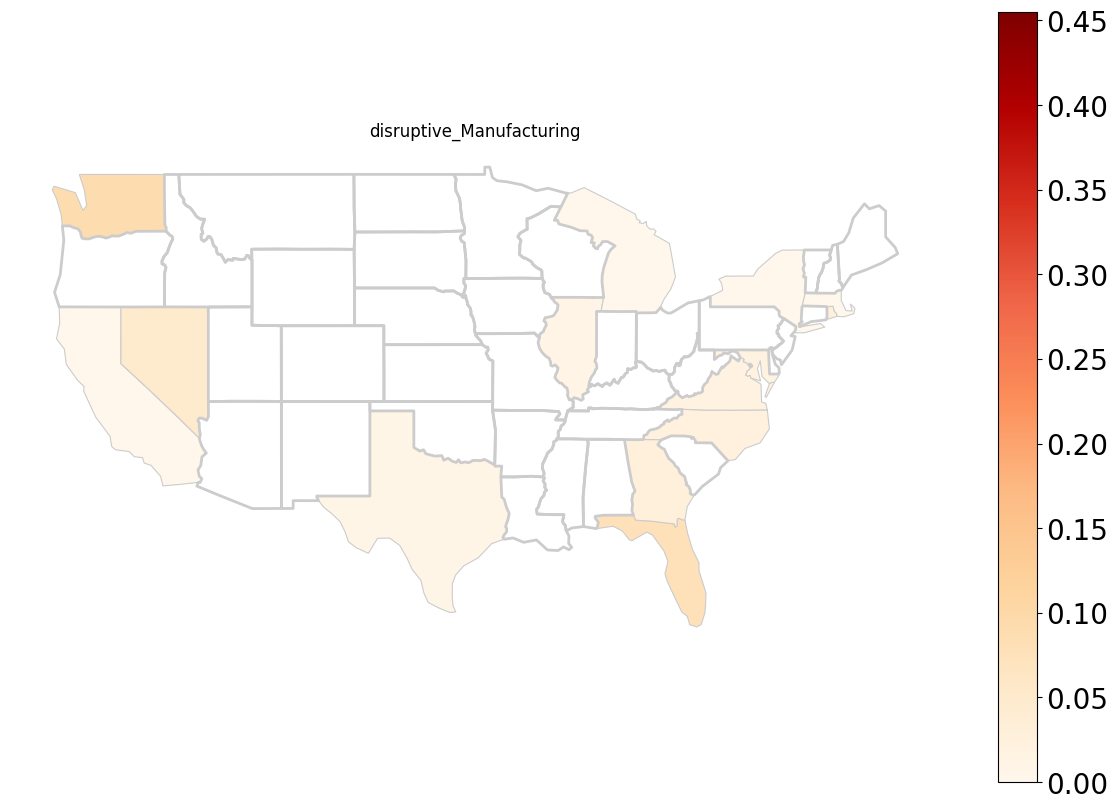

In [166]:
plot_by_sectors("disruptive", "Manufacturing")

/tmp/ipykernel_12200/3636884615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_exposedai['patent_id'] = tasks_exposedai['patent_id'].astype(str)
/tmp/ipykernel_12200/3636884615.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how="inner")
/tmp/ipykernel_12200/3636884615.py:48: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how

0.10944244283522991


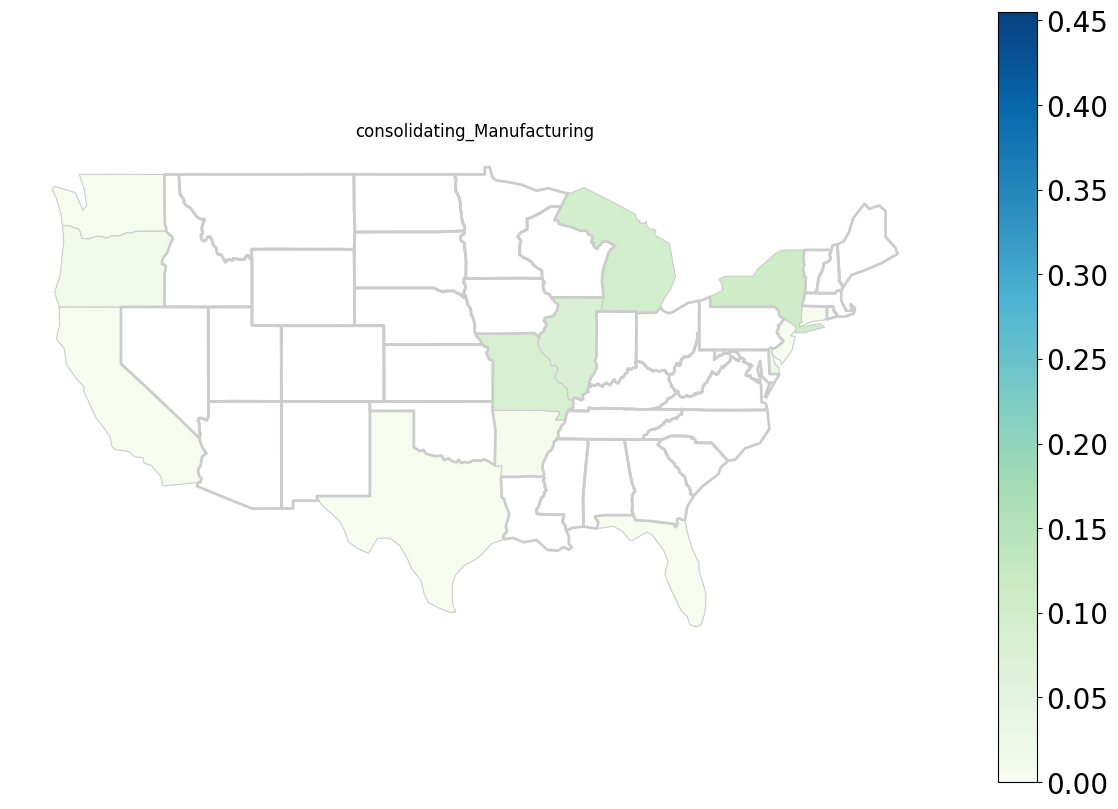

In [167]:
plot_by_sectors("consolidating", "Manufacturing")

/tmp/ipykernel_12200/3636884615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_exposedai['patent_id'] = tasks_exposedai['patent_id'].astype(str)
/tmp/ipykernel_12200/3636884615.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how="inner")
/tmp/ipykernel_12200/3636884615.py:48: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how

0.12572798903734156


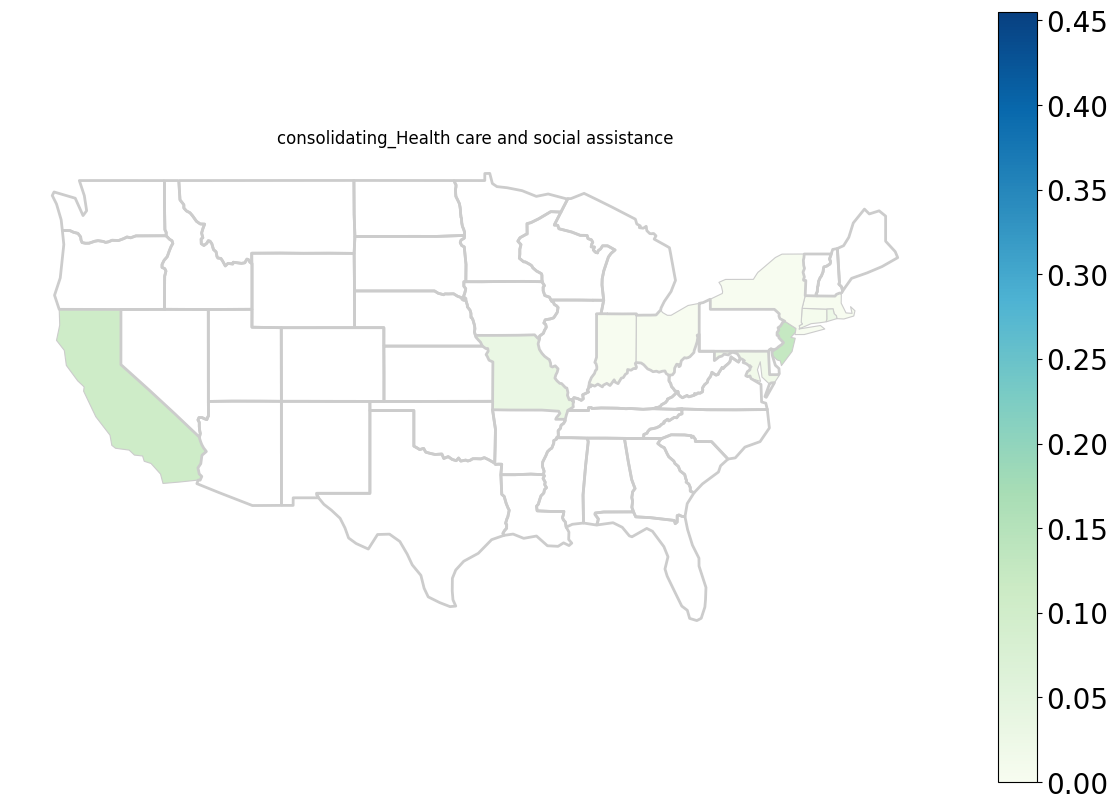

In [168]:
plot_by_sectors("consolidating", "Health care and social assistance")

/tmp/ipykernel_12200/3636884615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_exposedai['patent_id'] = tasks_exposedai['patent_id'].astype(str)
/tmp/ipykernel_12200/3636884615.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how="inner")
/tmp/ipykernel_12200/3636884615.py:48: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how

0.4540938677629326


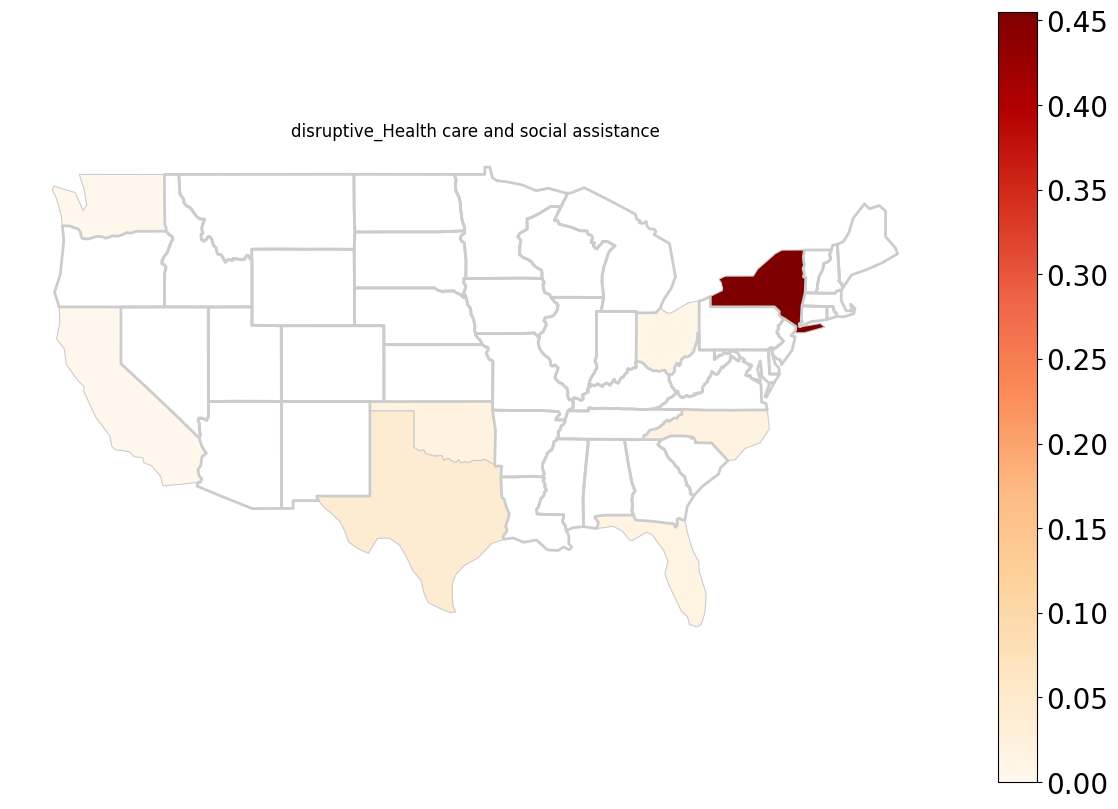

In [169]:
plot_by_sectors("disruptive", "Health care and social assistance")

/tmp/ipykernel_12200/3636884615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_exposedai['patent_id'] = tasks_exposedai['patent_id'].astype(str)
/tmp/ipykernel_12200/3636884615.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how="inner")
/tmp/ipykernel_12200/3636884615.py:48: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how

0.21118012422360247


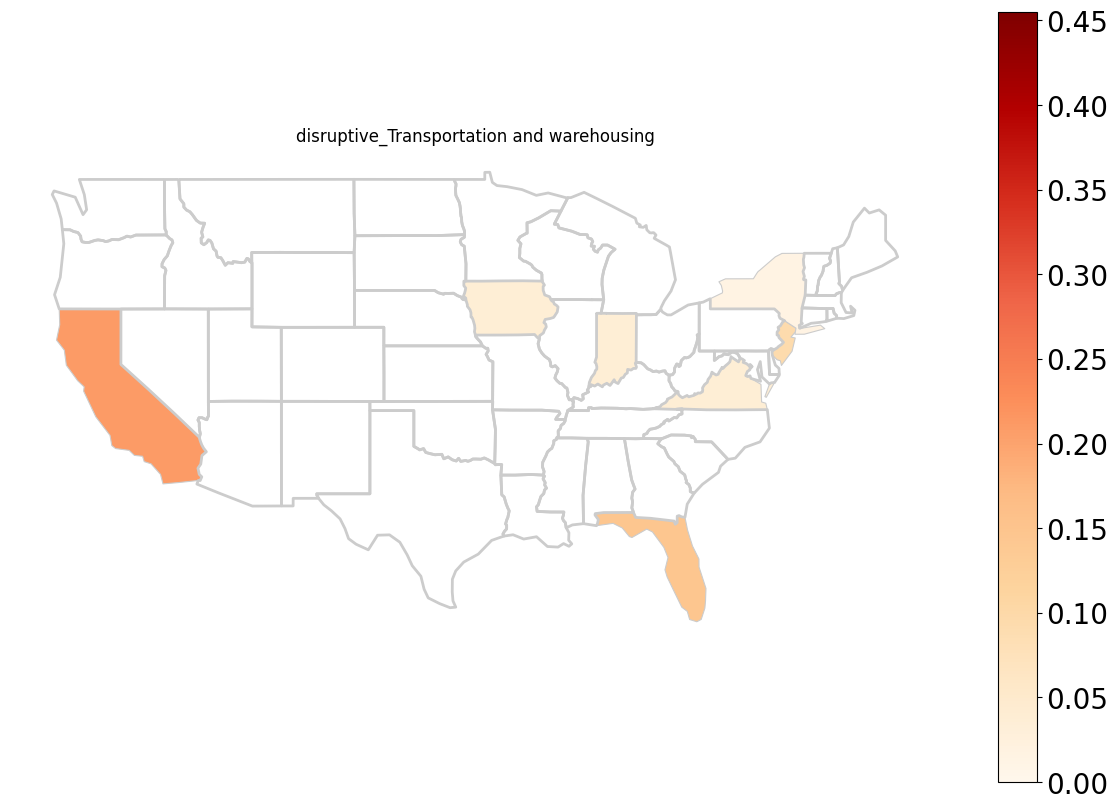

In [170]:
plot_by_sectors("disruptive", "Transportation and warehousing")

/tmp/ipykernel_12200/3636884615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_exposedai['patent_id'] = tasks_exposedai['patent_id'].astype(str)
/tmp/ipykernel_12200/3636884615.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how="inner")
/tmp/ipykernel_12200/3636884615.py:48: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how

0.2717391304347826


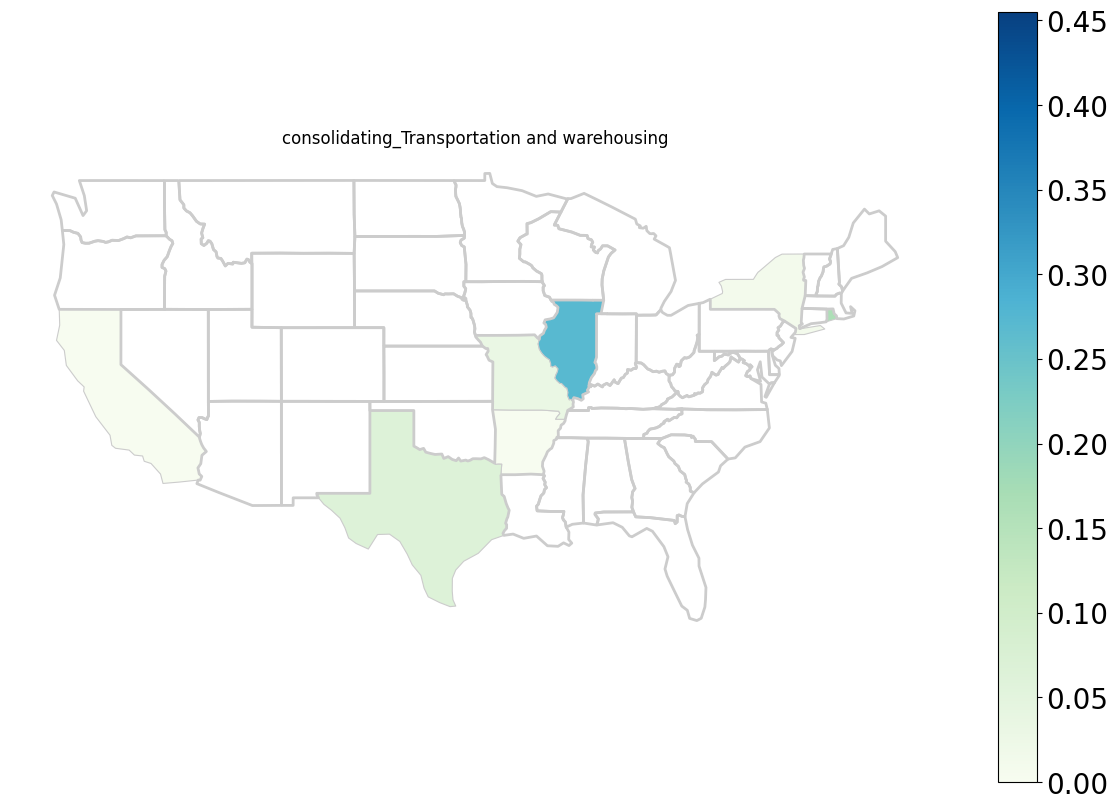

In [171]:
plot_by_sectors("consolidating", "Transportation and warehousing")

/tmp/ipykernel_12200/3636884615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_exposedai['patent_id'] = tasks_exposedai['patent_id'].astype(str)
/tmp/ipykernel_12200/3636884615.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how="inner")
/tmp/ipykernel_12200/3636884615.py:48: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how

0.12008978675645343


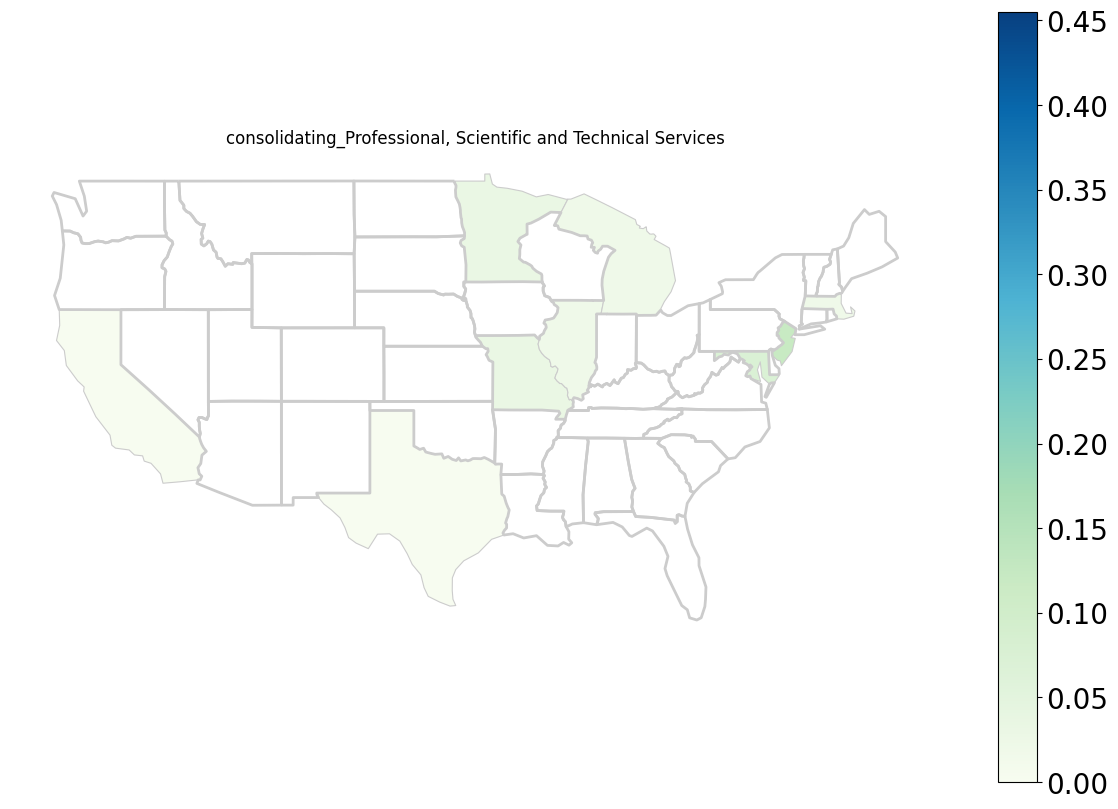

In [172]:
plot_by_sectors("consolidating", "Professional, Scientific and Technical Services")

/tmp/ipykernel_12200/3636884615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tasks_exposedai['patent_id'] = tasks_exposedai['patent_id'].astype(str)
/tmp/ipykernel_12200/3636884615.py:13: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how="inner")
/tmp/ipykernel_12200/3636884615.py:48: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, us_states, how

0.17356572258533043


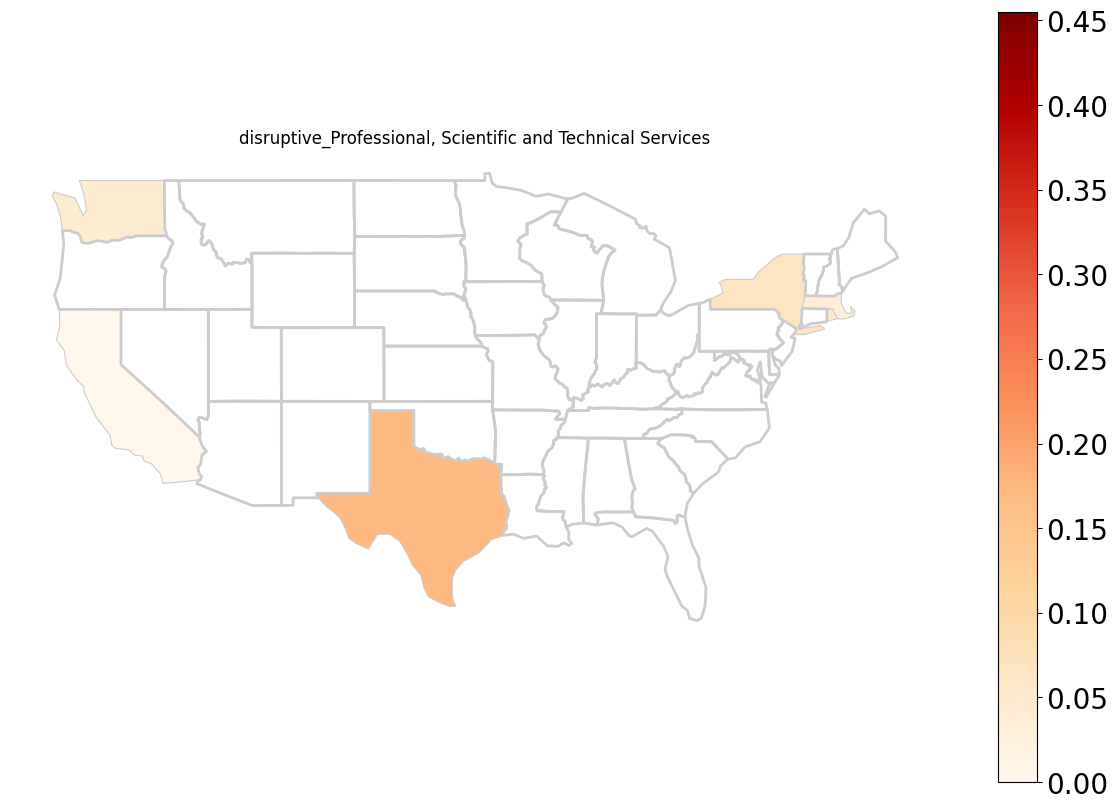

In [173]:
plot_by_sectors("disruptive", "Professional, Scientific and Technical Services")